## <span style="color:blue">Group 18 Phase 4 Project Submission</span>

# CURRENCY EXCHANGE RATE PREDICTION
<span style="color:blue">**Students names:**</span>
1. Francis Njenga
2. Thomas Okiwi
2. Leonard Gachimu

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px


import warnings

# Ignore documentation warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sphinx')

## Business Understanding

Analyzing BTC/USD for a data science project within the dynamic realm of forex trading requires a comprehensive and nuanced approach. The unique nature of Bitcoin, operating in a decentralized ecosystem, demands a departure from traditional fiat currency analysis. Fundamental factors such as macroeconomic indicators, regulatory shifts, and technological advancements are crucial in understanding BTC/USD dynamics. Moreover, the use of advanced algorithms and machine learning models, particularly in time series analysis, sentiment analysis, and pattern recognition, becomes imperative to unravel hidden trends and gain a predictive edge in the volatile cryptocurrency market.

A key pillar in this analysis is risk management, given the inherent volatility of BTC/USD. Robust risk mitigation strategies, driven by data-driven insights, allow forex companies to optimize position sizing, set appropriate stop-loss levels, and establish risk-reward ratios tailored to the unique characteristics of the cryptocurrency market. Additionally, real-time data feeds and APIs play a pivotal role in staying abreast of market developments, providing timely and accurate information crucial for seizing opportunities and avoiding losses in the fast-paced world of forex.

In conclusion, success in analyzing BTC/USD for a data science project within a forex company hinges on a holistic approach that integrates fundamental insights, technical acumen, and cutting-edge data science methodologies. By navigating the complexities of the cryptocurrency market with a well-rounded understanding, companies can make informed decisions, manage risks effectively, and foster sustainable success in this evolving landscape

## Data Understanding

Developing a time series model for BTC/USD involves a detailed analysis of historical price data spanning November 23 to November 25, 2023. Key metrics such as opening, closing, high, and low prices, along with trading volume and daily percentage changes, provide insights into the cryptocurrency's behavior. The closing prices fluctuated between $37,280.00 and $37,852.00, exhibiting intraday volatility, while trading volumes varied from 1.20K to 3.64K, indicating changing market participation. Daily percentage changes ranged from -0.34% to +1.14%, reflecting the inherent volatility of BTC/USD.

In this context, crucial considerations for the project include data preprocessing to handle missing values and outliers, as well as feature engineering to enhance model performance with additional indicators. Time series models such as ARIMA, SARIMA, or LSTM are recommended for capturing temporal patterns. The dataset should be split into training and validation sets, maintaining chronological order, and model evaluation should employ metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE). The iterative refinement process aims to continuously enhance the model's adaptability to evolving market conditions.

Ultimately, the goal of this BTC/USD time series project is to build a robust model capable of making informed predictions, considering both historical price trends and the dynamic nature of the cryptocurrency market. This approach ensures a comprehensive understanding of the data and facilitates the development of a model that can navigate the complexities of BTC/USD price movements with accuracy and adaptability.

In [44]:
stock= pd.read_csv("BTC_USD_Historical_Data.csv")
stock.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,11/29/2023,"38,046.70","37,823.30","38,362.90","37,686.50",67.23K,0.59%
1,11/28/2023,"37,823.30","37,244.30","38,379.40","36,881.10",57.50K,1.54%
2,11/27/2023,"37,248.60","37,451.80","37,563.30","36,751.50",45.24K,-0.54%
3,11/26/2023,"37,451.80","37,786.40","37,819.10","37,166.30",29.20K,-0.89%
4,11/25/2023,"37,787.00","37,718.60","37,887.40","37,599.90",16.09K,0.18%


In [45]:
stock.shape

(4883, 7)

In [46]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4883 entries, 0 to 4882
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      4883 non-null   object
 1   Price     4883 non-null   object
 2   Open      4883 non-null   object
 3   High      4883 non-null   object
 4   Low       4883 non-null   object
 5   Vol.      4877 non-null   object
 6   Change %  4883 non-null   object
dtypes: object(7)
memory usage: 267.2+ KB


In [47]:
# Number of missing values in dataframe
stock.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64

Since the values in volumn column are currently object type with irregular characters, it is not possible to compute measures of central tendency or plot a distribution of the values.
We therefore, cannot statitically determine what to replace the missing values with and since they are only 6 out of 4,883 rows, we chose to delete them.

In [48]:
# Delete rows with missing values
stock.dropna(inplace=True)

Inspect the value counts in volume column

In [49]:
stock['Vol.'].value_counts()

1.05M      6
1.18M      5
1.04M      5
14.73K     5
1.11M      4
          ..
85.72K     1
515.43K    1
21.91K     1
14.78K     1
937.97K    1
Name: Vol., Length: 4335, dtype: int64

The volume column has several unique values and we notice that they are ending with letters such as K and M to denote multiples of thousands, millions, and so on.
We will use a regex function to extract all the unique suffixes and one representative value per suffix. 

In [50]:
# Import regex
import re

# Extract rows with suffix letters using a regex expression
suffixes = stock['Vol.'].str.extract(r'(\D+)$')[0]

# Create a dictionary to store unique values for each suffix
unique_values = {}
for suffix in suffixes.unique():
    # Get values with the current suffix
    values_with_suffix = stock[stock['Vol.'].str.endswith(suffix)]['Vol.']
    # Get the first value for the suffix
    representative_value = values_with_suffix.iloc[0]
    unique_values[suffix] = representative_value

# Print the unique values for each suffix
for suffix, value in unique_values.items():
    print(f"Suffix {suffix}: {value}")
    
# Print rows without a suffix letter in the volume column
stock[~(stock['Vol.'].str.contains(r'(\D+)$'))]

Suffix K: 67.23K
Suffix M: 671.05M
Suffix B: 1.04B


c:\Users\thomas.okiwi.TECHNOBRAINBPO\anaconda3\envs\learn-env\lib\site-packages\pandas\core\strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



,Date,Price,Open,High,Low,Vol.,Change %


There are no values without a suffix letter. We will next strip the suffix letters, convert the remaining number to a float type and multiply it with the corresponding multiplier for the letter.

In [51]:
# Strip suffix letters from volume column and convert to respective numeric figure
for index, row in stock.iterrows():
    if 'K' in row['Vol.']:
        row_value = round(float(row['Vol.'].strip('K')) * 1000)
        stock.at[index, 'Vol.'] = row_value
    elif 'M' in row['Vol.']:
        row_value = round(float(row['Vol.'].strip('M')) * 1000000)
        stock.at[index, 'Vol.'] = row_value
    elif 'B' in row['Vol.']:
        row_value = round(float(row['Vol.'].strip('B')) * 1000000000)
        stock.at[index, 'Vol.'] = row_value       

In [52]:
# Confirm changes to volume column
stock

,Date,Price,Open,High,Low,Vol.,Change %
0,11/29/2023,"38,046.70","37,823.30","38,362.90","37,686.50",67230,0.59%
1,11/28/2023,"37,823.30","37,244.30","38,379.40","36,881.10",57500,1.54%
2,11/27/2023,"37,248.60","37,451.80","37,563.30","36,751.50",45240,-0.54%
3,11/26/2023,"37,451.80","37,786.40","37,819.10","37,166.30",29200,-0.89%
4,11/25/2023,"37,787.00","37,718.60","37,887.40","37,599.90",16090,0.18%
...,...,...,...,...,...,...,...
4878,7/22/2010,0.1,0.1,0.1,0.1,2160,0.00%
4879,7/21/2010,0.1,0.1,0.1,0.1,580,0.00%
4880,7/20/2010,0.1,0.1,0.1,0.1,260,0.00%
4881,7/19/2010,0.1,0.1,0.1,0.1,570,0.00%


In [53]:
stock['Change %'].str.extract(r'(%+)$')

,0
0,%
1,%
2,%
3,%
4,%
...,...
4878,%
4879,%
4880,%
4881,%


In [54]:
# Date data type is object converting it to date and time 
stock['Date'] = pd.to_datetime(stock['Date'], format='%m/%d/%Y')
print (stock.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4877 entries, 0 to 4882
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4877 non-null   datetime64[ns]
 1   Price     4877 non-null   object        
 2   Open      4877 non-null   object        
 3   High      4877 non-null   object        
 4   Low       4877 non-null   object        
 5   Vol.      4877 non-null   object        
 6   Change %  4877 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 464.8+ KB
None


In [55]:


# Remove commas from specified columns
stock[['Price', 'Open', 'High', 'Low']] = stock[['Price', 'Open', 'High', 'Low']].replace({',': ''}, regex=True)


# Remove percentage sign from the 'Change' column
stock['Change %'] = stock['Change %'].str.replace('%', '')

# Convert specified columns to float
stock[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']] = stock[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']].astype(float)


In [56]:
stock. info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4877 entries, 0 to 4882
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4877 non-null   datetime64[ns]
 1   Price     4877 non-null   float64       
 2   Open      4877 non-null   float64       
 3   High      4877 non-null   float64       
 4   Low       4877 non-null   float64       
 5   Vol.      4877 non-null   float64       
 6   Change %  4877 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 464.8 KB


In [57]:
import plotly.express as px


fig = px.line(stock, x='Date', y=['Price', 'High', 'Low'],
              title='Bitcoin Price Against USD Over Time')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='2023-Data', step='year', stepmode='backward'),
            dict(count=2, label='2022-2023-Data', step='year', stepmode='backward'),
            dict(count=3, label='2021-2023-Data', step='year', stepmode='backward'),
            dict(step='all')
        ])
    )
)

fig.show()


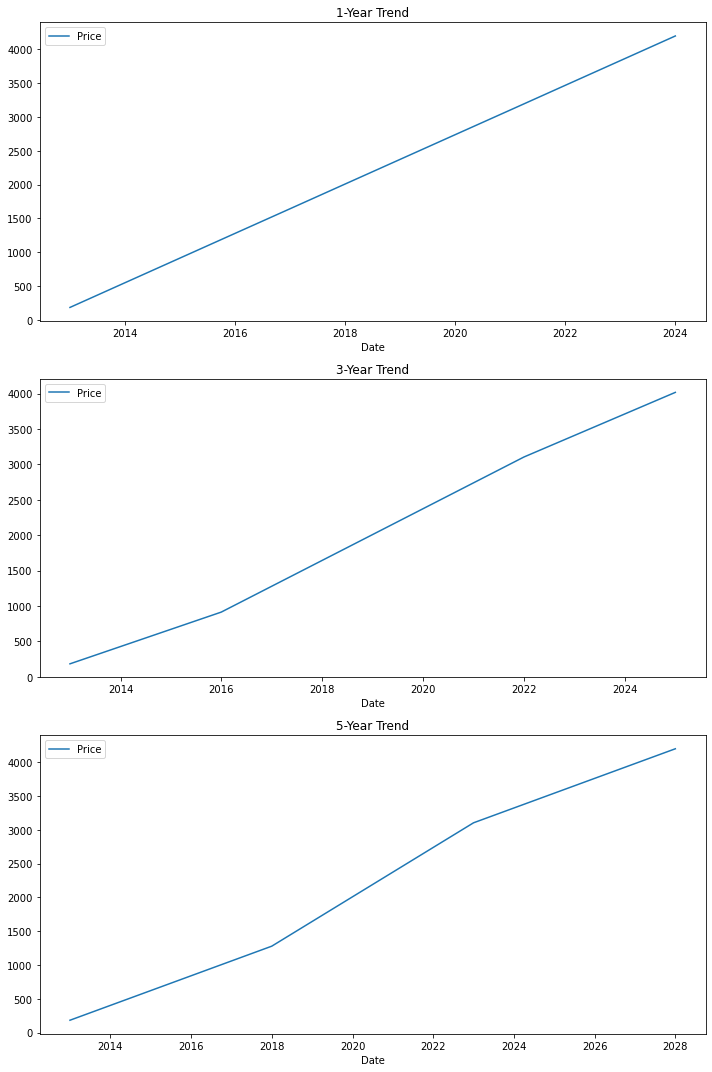

In [61]:

data = {'Date': pd.date_range(start='01/01/2012', end='12/31/2023'),
        'Price': [i for i in range(len(pd.date_range(start='01/01/2012', end='12/31/2023')))]}

stock= pd.DataFrame(data)
stock.set_index('Date', inplace=True)

# Visualize 1-year, 3-year, and 5-year trends
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 1-year trend
sns.lineplot(data=stock.resample('1Y').mean(), ax=axes[0])
axes[0].set_title('1-Year Trend')

# 3-year trend
sns.lineplot(data=stock.resample('3Y').mean(), ax=axes[1])
axes[1].set_title('3-Year Trend')

# 5-year trend
sns.lineplot(data=stock.resample('5Y').mean(), ax=axes[2])
axes[2].set_title('5-Year Trend')

# Adjust layout
plt.tight_layout()
plt.show()


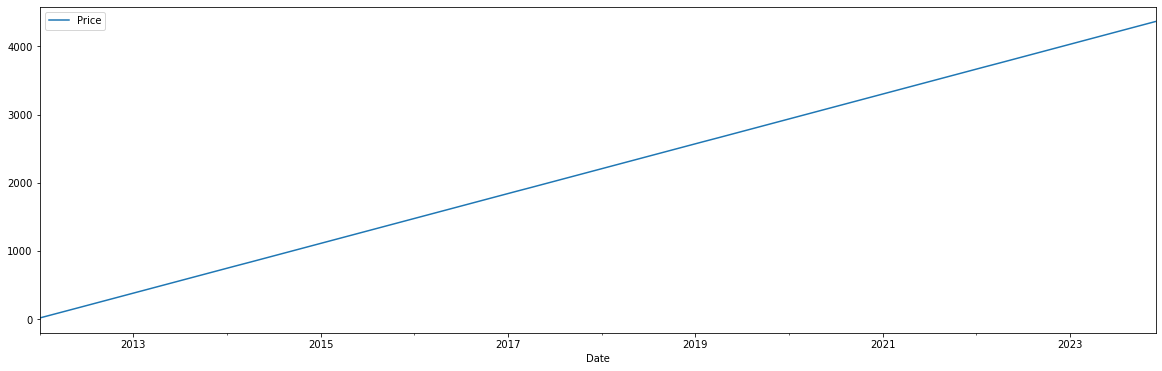

In [66]:
monthly_data=stock.resample('M')
monthly= monthly_data.mean()
monthly.plot(figsize = (20,6))
plt.show()

c:\Users\thomas.okiwi.TECHNOBRAINBPO\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



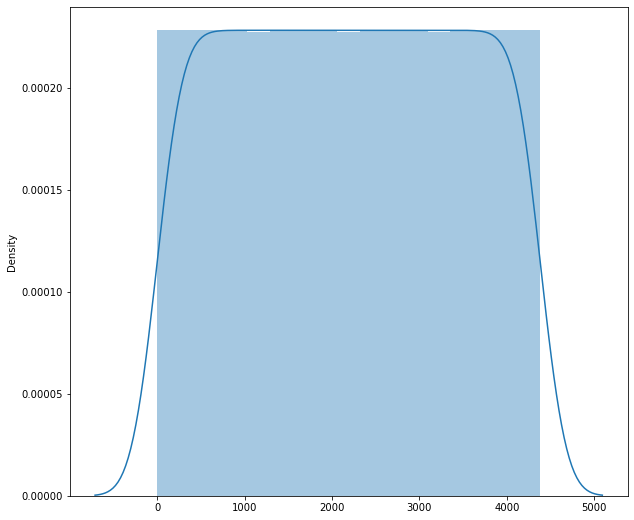

In [69]:
plt.figure(figsize=(10, 9))
sns.distplot(stock, kde=True)

# Show the plot
plt.show()